In [1]:
import xml.etree.ElementTree as ET
import os
from datetime import datetime
from collections import defaultdict

DATA_ROOT_DIR = "../../data"
DATA_DIR_AUTO = f"{DATA_ROOT_DIR}/final/transcripts/auto"
DATA_DIR_MANUAL = f"{DATA_ROOT_DIR}/final/transcripts/manual"
DATA_DIR_BEFORE_REVIEW = f"{DATA_ROOT_DIR}/final/transcripts/before_review"
DATA_DIR_ASR_VERSIONS = f"{DATA_ROOT_DIR}/final/asr_outputs"
PREFERENCE_ORDER = ['whisper', 'mixed', 'scratch']
SPEAKER_TYPES = ['exam', 'cand']
ANNOTATOR_NAMES = ['KR', 'MR', 'MH', 'AP', 'ET', 'KV', 'LR', 'ZM']

annotation2annot_duration = {}
annotation2duration = {}
annotation2duration_per_speaker = defaultdict(dict)

def parse_xml_file(xml_file_path, is_manual=False):

    tree = ET.parse(xml_file_path)

    root = tree.getroot()
    recording = None
    for r in root.iter('media'):
        recording = r.attrib['url']
        break
    assert recording is not None

    root = tree.getroot()
    annot_duration = 0
    for r in root.iter('annotDuration'):
        annot_duration += float(r.text)

    #TODO: this is a foo value
    duration = 0
    duration_per_speaker = defaultdict(int)

    utterances = []
    last_end = -1
    for u in root.iter('u'):
        if u.text is not None and len(u.text) > 0:
            #if last_end > float(u.attrib['start']):
            #    print(f"Overlapping utterances in {xml_file_path}")
            last_end = float(u.attrib['end'])
            utterances.append({
                'start': float(u.attrib['start']),
                'end': float(u.attrib['end']),
                'text': u.text,
                'speaker': u.attrib['who'].lower(),
                'source': u.attrib['source'] if 'source' in u.attrib else None
            })
            duration += float(u.attrib['end']) - float(u.attrib['start'])
            duration_per_speaker[u.attrib['who'].lower()] += float(u.attrib['end']) - float(u.attrib['start'])
    transcript_basename = os.path.basename(xml_file_path)
    annotation2duration[transcript_basename] = max(annotation2duration.get(recording, 0), duration)
    annotation2duration[recording] = max(annotation2duration.get(recording, 0), duration)
    if is_manual:
        annotation2duration_per_speaker[transcript_basename] = {k: max(annotation2duration_per_speaker[transcript_basename].get(k, 0), v) for k, v in duration_per_speaker.items()}
        annotation2duration_per_speaker[recording] = {k: max(annotation2duration_per_speaker[recording].get(k, 0), v) for k, v in duration_per_speaker.items()}
    # print(xml_file_path, duration, annot_duration, len(utterances))
    return recording, utterances, annot_duration


def transcript_version_select(transcripts):
    for p in PREFERENCE_ORDER:
        for n, t in transcripts.items():
            if p in n:
                return t
    return next(iter(transcripts.values()))

def load_transcripts(data_dir, is_manual=False):
    recordings = {}
    annot_durations = {}

    for xmlfile in os.listdir(data_dir):
        if not xmlfile.endswith('.xml'):
            continue
        # skip all recordings that are not pure A2 level
        if 'A2' not in xmlfile or 'bA2' in xmlfile or 'uA2' in xmlfile:
            continue
        # skip transcripts annotated by KR and MR: they lack the transcript of the examiner
        if 'KR' in xmlfile or 'MR' in xmlfile:
            continue
        recording, utterances, annot_duration = parse_xml_file(os.path.join(data_dir, xmlfile), is_manual)
        annotations = recordings.get(recording, {})
        annotations[xmlfile] = utterances
        annot_durations[xmlfile] = annot_duration
        recordings[recording] = annotations
    return recordings, {annot_name: annot for _, annotations in recordings.items() for annot_name, annot in annotations.items()}, annot_durations

manual_recordings, manual_annotations, manual_annot_durations = load_transcripts(DATA_DIR_MANUAL, is_manual=True)
auto_recordings, auto_annotations, _ = load_transcripts(DATA_DIR_AUTO)
before_review_recordings, before_review_annotations, before_review_annot_durations = load_transcripts(DATA_DIR_BEFORE_REVIEW, is_manual=True)

auto_recordings_versions = {}
for ver_name in os.listdir(DATA_DIR_ASR_VERSIONS):
    path = os.path.join(DATA_DIR_ASR_VERSIONS, ver_name)
    if os.path.isdir(path):
        recordings, annotations, _ = load_transcripts(path)
        auto_recordings_versions[ver_name] = annotations

### Basic statistics

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Apply the seaborn theme
sns.set_theme(style="whitegrid")

os.makedirs('figures', exist_ok=True)

forstat_recordings = before_review_recordings
#forstat_recordings = manual_recordings
forstat_annotations = before_review_annotations
#forstat_annotations = manual_annotations

print(f"Number of recordings: {len(forstat_recordings)}")
print(f"Total length of recordings: {sum([annotation2duration[rec] for rec in forstat_recordings])/60} minutes")
print(f"Avg length of recording: {sum([annotation2duration[rec] for rec in forstat_recordings]) / len(forstat_recordings)} seconds")
recording_lengths_per_speaker = defaultdict(int)
for speaker_type in SPEAKER_TYPES:
    length_per_speaker_type = sum([annotation2duration_per_speaker[rec][speaker] for rec in forstat_recordings for speaker in annotation2duration_per_speaker[rec] if speaker.startswith(speaker_type)])
    print(f"Total length of recordings for {speaker_type}: {length_per_speaker_type/60} minutes")

print(f"Number of transcripts: {len(forstat_annotations)}")
print(f"Number of recording with more than a one transcript: {len([rec for rec, annots in forstat_recordings.items() if len(annots) > 1])}")

# histogram of the number of transcripts per recordin
for recname, annots in forstat_recordings.items():
    if len(annots) > 1:
        print(recname, len(annots))
transcripts_per_recording = [len(annots) for annots in forstat_recordings.values()]

# Calculate bin edges and midpoints
bin_edges = range(1, max(transcripts_per_recording) + 2)
bin_midpoints = [(edge + bin_edges[i+1])/2 for i, edge in enumerate(bin_edges[:-1])]
# Plot histogram
plt.figure(figsize=(7.5, 4.5))  # Set the figure size to adjust the height and width
#plt.hist(transcripts_per_recording, bins=bin_edges)
sns.histplot(transcripts_per_recording, bins=bin_edges, kde=False)
plt.xticks(bin_midpoints, labels=[str(int(x)) for x in bin_midpoints])  # Set the x-ticks to the midpoints, converting them to string if needed
#plt.title('Number of transcripts per recording')
plt.xlabel('Number of transcripts')
plt.ylabel('Number of recordings')
plt.savefig('figures/transcripts_per_recording.pdf', format='pdf')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

stats_annot_durations = before_review_annot_durations

relevant = [
    duration for annot, duration in stats_annot_durations.items()
]

print(f"Number of transcripts for which we measured duration: {len([duration for duration in relevant if duration > 0])}")

# Plotting the histogram
plt.hist(relevant, bins=100)

# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Displaying the histogram
plt.show()

# print annotations with duration more than 10000 seconds
for annot, duration in stats_annot_durations.items():
    if duration > 10000:
        print(annot, duration)

In [ ]:
import matplotlib.pyplot as plt

stats_annot_durations = before_review_annot_durations

relevant = [
    duration / annotation2duration[annot] for annot, duration in stats_annot_durations.items()
]

# Plotting the histogram
plt.hist(relevant, bins=100)

# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Displaying the histogram
plt.show()

# print annotations with duration more than 10000 seconds
for annot, duration in stats_annot_durations.items():
    if duration / annotation2duration[annot] > 30:
        print(annot, duration)

In [ ]:
stats_annot_durations = before_review_annot_durations

data = []
for t in PREFERENCE_ORDER:
    relevant = [
        # The sessions where TEITOK timed out have been already filtered out. No need of filtering out durations longer than 10000 seconds.
        #duration / annotation2duration[annot] for annot, duration in stats_annot_durations.items() if t in annot and 10000 > duration > 0
        duration / annotation2duration[annot] for annot, duration in stats_annot_durations.items() if t in annot and duration > 0
    ]
    data.append([v for v in relevant])

# plot three histograms in 3D plot
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim=250)
for i, d in enumerate(reversed(data)):
    hist, bins = np.histogram(d, bins=100)
    xs = (bins[:-1] + bins[1:]) / 2
    ax.bar(xs, hist, zs=i, zdir='y', alpha=0.8)

fig.legend(list(reversed(PREFERENCE_ORDER)))

for i, t in enumerate(PREFERENCE_ORDER):
    relevant = data[i]
    print(f"Average duration for {t}: {sum(relevant)/len(relevant)}")
    print(f"Max duration for {t}: {max(relevant)}")
    print(f"Min duration for {t}: {min(relevant)}")


In [ ]:
%load_ext autoreload
%autoreload 2

import uttalign

def sample_alignment():
    #key = list(before_review_annotations.keys())[0]
    key = "A2ML_221205_07-ET-from_mixed.xml"
    print(key)
    before_review_annotation = before_review_annotations[key]
    auto_annotation = auto_annotations[key]
    #uttaligner = uttalign.MatrixAligner()
    uttaligner = uttalign.BioAligner()

    alignment = uttaligner.align_utterances(before_review_annotation, auto_annotation)

    print(alignment)
    
    aligned_texts = [(uttalign.extract_text(i, before_review_annotation), uttalign.extract_text(j, auto_annotation)) for i, j in alignment]
    aligned_speakers = [(uttalign.extract_speaker(i, before_review_annotation), uttalign.extract_speaker(j, auto_annotation)) for i, j in alignment]

    print(aligned_texts)
    print(aligned_speakers)

    #print_alignment(alignments, before_review_annotation, auto_annotation)

sample_alignment()

## RQ1: Is manual post-editting of ASR outputs more eﬀicient than manual transcription?

In [24]:
# take only the transcripts where the annotation duration was logged
stats_annot_durations = {annot: duration for annot, duration in before_review_annot_durations.items() if duration > 0}
stats_annotations = before_review_annotations
print(len(stats_annot_durations.keys()))

75


['KV', 'LR', 'ZM', 'AP', 'ET']
[9.223773704314999, 13.763853771291195, 8.963831605921737, 17.999264479245387, 10.720651003076659]


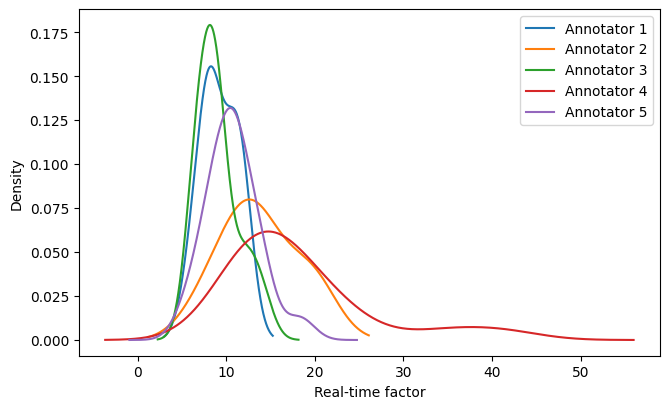

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# real-time factor for each annotator
rtf_per_user = defaultdict(list)

for annot_name, duration in stats_annot_durations.items():
    rtf = duration / annotation2duration[annot_name]
    user = annot_name.split('-')[1]
    rtf_per_user[user].append(rtf)

#color = plt.rainbow(np.linspace(0, 1, len(overall_times_per_user.keys())))

print(list(rtf_per_user.keys()))
print([np.mean(times) for times in rtf_per_user.values()])


legend_labels = [f"Annotator {i}" for i in range(1, len(rtf_per_user.keys())+1)]
fig, ax = plt.subplots()
annot_speed_df = pd.DataFrame({user: pd.Series(times) for user, times in rtf_per_user.items()})
annot_speed_df.plot(kind='density', ax=ax)
ax.legend(legend_labels)
ax.set_xlabel('Real-time factor')
#ax.set_xlim(0, 50)
# set the figure size
fig.set_size_inches(7.5, 4.5)
#plt.title('Histogram of overall times per user')
fig.savefig('figures/annot-speed-per-user.pdf', format="pdf")
#plt.ylabel('Frequency')
#plt.show()

In [ ]:
from collections import defaultdict

from Bio.pairwise2 import format_alignment

%load_ext autoreload
%autoreload 2
import uttalign
import utils

def calculate_edit_distances(to_annotations, from_annotations, align_directory=None):

    if align_directory is not None:
        os.makedirs(align_directory, exist_ok=True)

    to_from_annot_pairs = {annot_name:(to_annotations[annot_name], from_annotations[annot_name]) for annot_name in to_annotations}

    aligner = uttalign.BioAligner()
    # aligner = uttalign.MatrixAligner(threshold_overlap=0.1)

    edit_counts = {speaker_type: defaultdict(list) for speaker_type in SPEAKER_TYPES + ['all']} 
    to_lengths = {speaker_type: defaultdict(list) for speaker_type in SPEAKER_TYPES + ['all']}
    ceds = {speaker_type: defaultdict(list) for speaker_type in SPEAKER_TYPES + ['all']}

    for annot_name, (to_annot, from_annot) in to_from_annot_pairs.items():
        # create empty file for alignment
        if align_directory is not None:
            with open(f'{align_directory}/{annot_name}.txt', 'w') as f:
                f.write("")
        
        for transcript_type in PREFERENCE_ORDER:
            if transcript_type in annot_name:
                break
        
        utt_alignment = aligner.align_utterances(to_annot, from_annot)

        aligned_texts = [(uttalign.extract_text(i, to_annot), uttalign.extract_text(j, from_annot)) for i, j in utt_alignment]
        aligned_speakers = [(uttalign.extract_speaker(i, to_annot), uttalign.extract_speaker(j, from_annot)) for i, j in utt_alignment]

        edit_count = {speaker_type: 0 for speaker_type in SPEAKER_TYPES + ['all']}
        to_length = {speaker_type: 0 for speaker_type in SPEAKER_TYPES + ['all']}

        for (to_text, from_text), (to_speaker, from_speaker) in zip(aligned_texts, aligned_speakers):
            speaker_type = to_speaker
            if to_speaker is not None:
                for speaker_type in SPEAKER_TYPES:
                    if speaker_type.lower() in to_speaker.lower():
                        break
            l = len(utils.normalize_text(to_text, char_level=True))
            #l = len([c for c in before_review_text])
            #print(before_review_text, auto_text)
            agree, disagree, word_alignment = uttalign.align_texts(to_text, from_text, char_level=True)
            # if l and disagree / l > 0.9:
            #     print(f"{annot_name} {before_review_speaker} {transcript_type} {agree} {disagree}")
            # append alignment to file
            if align_directory is not None:
                with open(f'{align_directory}/{annot_name}.txt', 'a') as f:
                    f.write(f"SPEAKER_TYPE: {speaker_type}\n")
                    if word_alignment is not None:
                        f.write(format_alignment(*word_alignment))
                    else:
                        f.write(f"{to_text}\n------------{from_text}\n")
            if speaker_type:
                edit_count[speaker_type] += disagree
                to_length[speaker_type] += l
            edit_count['all'] += disagree
            to_length['all'] += l
        
        for speaker_type in SPEAKER_TYPES + ['all']:
            edit_counts[speaker_type][transcript_type].append(edit_count[speaker_type])
            to_lengths[speaker_type][transcript_type].append(to_length[speaker_type])
            ceds[speaker_type][transcript_type].append(edit_count[speaker_type] / to_length[speaker_type] if to_length[speaker_type] > 0 else 0)
            edit_counts[speaker_type]['all'].append(edit_count[speaker_type])
            to_lengths[speaker_type]['all'].append(to_length[speaker_type])
            ceds[speaker_type]['all'].append(edit_count[speaker_type] / to_length[speaker_type] if to_length[speaker_type] > 0 else 0)
    return ceds, edit_counts, to_lengths

ceds, edit_counts, to_lengths = calculate_edit_distances(stats_annotations, auto_annotations, align_directory='alignments/rq1.1chars')

# print('Edit distances:     ', "\t".join([f"{k}:{v}" for k, v in edit_distances.items()]))
# print('Total characters:   ', "\t".join([f"{k}:{v}" for k, v in to_lengths.items()]))
# print('Edits per character:', "\t".join([f"{k}:{v / to_lengths[k]:.2f}" for k, v in edit_distances.items()]))
# print('Edits per character (macro avg across utts):', "\t".join([f"{k}:{v / macro_avg_count[k]:.2f}" for k, v in macro_avg_edit_distance.items()]))

# #columns = ['whisper', 'mixed', 'scratch']
# columns = ['whisper', 'mixed']
# values = [to_lengths[c] for c in columns]
# relativ = [edit_distances[c] / to_lengths[c] for c in columns]
# fig, ax = plt.subplots()
# ax.bar(columns, relativ)
# ax.set_ylabel('Edit distance per character')

### Comparison over all recordings: annotation time per recording, real-time factor, standardized RTF, character edit distance.

In [ ]:
import numpy as np
from jinja2 import Environment, FileSystemLoader

os.makedirs('tables', exist_ok=True)

annotdurations = defaultdict(list)
rtfs = defaultdict(list)
normed_rtfs = defaultdict(list)
#edits = defaultdict(lambda: 0)
#words = defaultdict(lambda: 0)

rtfs_per_user_means = {user: np.mean(times) for user, times in rtf_per_user.items()}
rtfs_per_user_stds = {user: np.std(times) for user, times in rtf_per_user.items()}

for annot_name in stats_annot_durations.keys():
    for t in PREFERENCE_ORDER:
        if t in annot_name:
            break
    #if -1 < stats_annot_durations[annot_name] < 10000: #TODO: this is
    
    annotdurations[t].append(stats_annot_durations[annot_name])
    annotdurations['all'].append(stats_annot_durations[annot_name])
    
    rtf = stats_annot_durations[annot_name] / annotation2duration[annot_name]
    rtfs[t].append(rtf)
    rtfs['all'].append(rtf)
    
    user = annot_name.split('-')[1]
    normed_rtf = (rtf - rtfs_per_user_means[user]) / rtfs_per_user_stds[user]
    normed_rtfs[t].append(normed_rtf)
    normed_rtfs['all'].append(normed_rtf)
    #edits[t] += annot2edit_distances[annot_name]
    #words[t] += annot2numwords[annot_name]

row_names = ["WhisperX", "Mixed", "From scratch", "All"]

table_dict = {"method": [], "annottime_mean": [], "annottime_std": [], "rtf_mean": [], "rtf_std": [], "normed_rtf_mean": [], "normed_rtf_std": []}
for speaker_type in SPEAKER_TYPES + ['all']:
    table_dict["ced_mean_" + speaker_type] = []
    table_dict["ced_std_" + speaker_type] = []
for i, t in enumerate(PREFERENCE_ORDER + ['all']):
    table_dict["method"].append(row_names[i])
    table_dict["annottime_mean"].append(np.mean(annotdurations[t]))
    table_dict["annottime_std"].append(np.std(annotdurations[t]))
    table_dict["rtf_mean"].append(np.mean(rtfs[t]))
    table_dict["rtf_std"].append(np.std(rtfs[t]))
    table_dict["normed_rtf_mean"].append(np.mean(normed_rtfs[t]))
    table_dict["normed_rtf_std"].append(np.std(normed_rtfs[t]))
    for speaker_type in SPEAKER_TYPES + ['all']:
        table_dict["ced_mean_" + speaker_type].append(np.mean(ceds[speaker_type][t]))
        table_dict["ced_std_" + speaker_type].append(np.std(ceds[speaker_type][t]))

table = pd.DataFrame(table_dict)
headers = [
    ["\multirow{2}{*}{Method}", "\multirow{2}{*}{\makecell{Annot. time \\\\ per recording (s)}}", "\multirow{2}{*}{RTF}", "\multirow{2}{*}{\makecell{Standardized \\\\ RTF}}", "\multicolumn{3}{c}{CER (\%)}"],
    ["", "", "", "", "Examiners", "Candidates", "All"]
]

with open('tables/annot_times.tex', 'w') as f:
    f.write(r"\begin{tabular}{l ccc ccc}" + "\n")
    f.write(r"\toprule" + "\n")
    for i, header in enumerate(headers):
        f.write(" & ".join(header) + r" \\" + "\n")
        if i == 0:
            f.write(r"\cmidrule(l){5-7}" + "\n")
    f.write(r"\midrule" + "\n")
    for i in range(len(PREFERENCE_ORDER)):
        cells = [
            table_dict['method'][i],
            f"{table_dict['annottime_mean'][i]:.2f} $\pm$ {table_dict['annottime_std'][i]:.2f}",
            f"{table_dict['rtf_mean'][i]:.2f} $\pm$ {table_dict['rtf_std'][i]:.2f}",
            f"{table_dict['normed_rtf_mean'][i]:.2f} $\pm$ {table_dict['normed_rtf_std'][i]:.2f}",
            f"{table_dict['ced_mean_exam'][i]*100:.2f} $\pm$ {table_dict['ced_std_exam'][i]*100:.2f}",
            f"{table_dict['ced_mean_cand'][i]*100:.2f} $\pm$ {table_dict['ced_std_cand'][i]*100:.2f}",
            f"{table_dict['ced_mean_all'][i]*100:.2f} $\pm$ {table_dict['ced_std_all'][i]*100:.2f}"
        ]
        f.write(" & ".join(cells) + r" \\" + "\n")
    f.write(r"\midrule" + "\n")
    cells = [
        table_dict['method'][-1],
        f"{table_dict['annottime_mean'][-1]:.2f} $\pm$ {table_dict['annottime_std'][-1]:.2f}",
        f"{table_dict['rtf_mean'][-1]:.2f} $\pm$ {table_dict['rtf_std'][-1]:.2f}",
        f"{abs(table_dict['normed_rtf_mean'][-1]):.2f} $\pm$ {table_dict['normed_rtf_std'][-1]:.2f}",
        f"{table_dict['ced_mean_exam'][-1]*100:.2f} $\pm$ {table_dict['ced_std_exam'][-1]*100:.2f}",
        f"{table_dict['ced_mean_cand'][-1]*100:.2f} $\pm$ {table_dict['ced_std_cand'][-1]*100:.2f}",
        f"{table_dict['ced_mean_all'][-1]*100:.2f} $\pm$ {table_dict['ced_std_all'][-1]*100:.2f}"
    ]
    f.write(" & ".join(cells) + r" \\" + "\n")
    f.write(r"\bottomrule" + "\n")
    f.write(r"\end{tabular}" + "\n")

#df = pd.DataFrame(table_dict)
#df.to_latex('tables/annot_times.tex', header=headers, float_format="%.2f", index=False)

print(table)

#print('Total times: ', durations)
#print('Edit distances:', edits)
#print('Annot to recording ratio:', [(k, annotdurations[k] / v) for k, v in durations.items()])
#print('Annot time per word:', [(k, annotdurations[k] / v) for k, v in words.items()])
#print('Annot duration per edit:', [(k, annotdurations[k] / v) for k, v in edits.items()])
#print('Edit distance per word:', [(k, v / words[k]) for k, v in edits.items()])

## RQ2: Does post-editing enhance transcripts’ consistency? Inter-annotator agreement

In [ ]:
# we are interested only in recordings with multiple transcripts
stats_recordings = {recname: annots for recname, annots in before_review_recordings.items() if len(annots) > 1 and "npi" not in recname}
print(len(stats_recordings.keys()))

In [28]:
uttaligner = uttalign.BioAligner()

table_dict = {"annotator1": [], "type1": [], "annotator2": [], "type2": [], "iaa12": [], "iaa21": [], "iaa": []}

for recname, annots in stats_recordings.items():
    # iterate over all pairs of transcripts
    for i, (annot1_name, annot1) in enumerate(annots.items()):
        for annot1_type in PREFERENCE_ORDER:
            if annot1_type in annot1_name:
                break
        for user1 in ANNOTATOR_NAMES:
            if user1 in annot1_name:
                break
        for j, (annot2_name, annot2) in enumerate(annots.items()):
            if i >= j:
                continue
            for annot2_type in PREFERENCE_ORDER:
                if annot2_type in annot2_name:
                    break
            for user2 in ANNOTATOR_NAMES:
                if user2 in annot2_name:
                    break
            # align the transcripts. It should be both_manual=True here, but the results are a bit weird and hard to explain. It needs to be investigated.
            # alignment = uttaligner.align_utterances(annot1, annot2, both_manual=True)
            alignment = uttaligner.align_utterances(annot1, annot2, both_manual=True)
            aligned_texts = [(uttalign.extract_text(i, annot1), uttalign.extract_text(j, annot2)) for i, j in alignment]
            aligned_speakers = [(uttalign.extract_speaker(i, annot1), uttalign.extract_speaker(j, annot2)) for i, j in alignment]

            edit_count = 0
            length1 = 0
            length2 = 0

            for (text1, text2), (speaker1, speaker2) in zip(aligned_texts, aligned_speakers):
                l1 = len(utils.normalize_text(text1, char_level=True))
                l2 = len(utils.normalize_text(text2, char_level=True))
                agree, disagree, word_alignment = uttalign.align_texts(text1, text2, char_level=True)
                edit_count += disagree
                length1 += l1
                length2 += l2

            iaa12 = 1 - (edit_count / length1) if length1 > 0 else 0
            iaa21 = 1 - (edit_count / length2) if length2 > 0 else 0
            iaa = (iaa12 + iaa21) / 2

            table_dict["annotator1"].append(user1)
            table_dict["type1"].append(annot1_type)
            table_dict["annotator2"].append(user2)
            table_dict["type2"].append(annot2_type)
            table_dict["iaa12"].append(iaa12)
            table_dict["iaa21"].append(iaa21)
            table_dict["iaa"].append(iaa)

rq2_df = pd.DataFrame(table_dict)
print(rq2_df)
            


   annotator1    type1 annotator2    type2     iaa12     iaa21       iaa
0          KV  whisper         ZM  whisper  0.893262  0.896949  0.895105
1          KV  whisper         ET    mixed  0.898629  0.903189  0.900909
2          ZM  whisper         ET    mixed  0.915947  0.916856  0.916402
3          AP    mixed         ZM    mixed  0.916507  0.915616  0.916061
4          KV    mixed         ZM    mixed  0.951570  0.952306  0.951938
5          KV  whisper         ZM    mixed  0.935816  0.936989  0.936402
6          KV  whisper         ET  whisper  0.904949  0.907443  0.906196
7          ZM    mixed         ET  whisper  0.901395  0.902195  0.901795
8          ET  scratch         AP  scratch  0.951049  0.949940  0.950495
9          ET  scratch         AP  scratch  0.801214  0.794992  0.798103
10         ET  scratch         ZM    mixed  0.934554  0.933107  0.933830
11         ET  scratch         AP  whisper  0.877427  0.867267  0.872347
12         ET  scratch         KV  scratch  0.84914

0.8789902152777912
0.058133476168108836


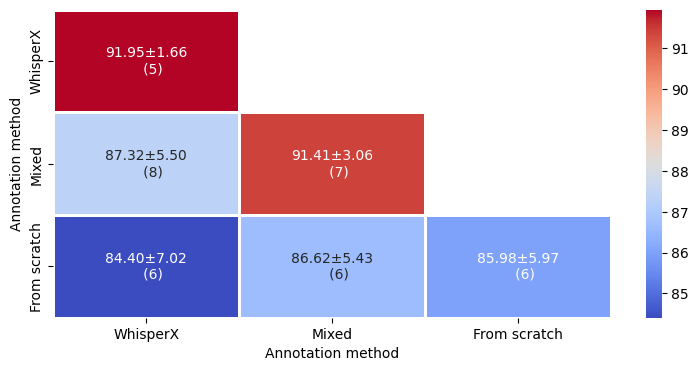

In [29]:
print(np.mean([row['iaa'] for i, row in rq2_df.iterrows()]))
print(np.std([row['iaa'] for i, row in rq2_df.iterrows()]))

# calculate IAAs across types
iaa_means_per_type = {t1: {} for t1 in PREFERENCE_ORDER}
iaa_stds_per_type = {t1: {} for t1 in PREFERENCE_ORDER}
iaa_counts_per_type = {t1: {} for t1 in PREFERENCE_ORDER}
for t1 in PREFERENCE_ORDER:
    for t2 in PREFERENCE_ORDER:
        iaas = [row['iaa']*100 for i, row in rq2_df.iterrows() 
                                         if (row['type1'] == t1 and row['type2'] == t2) or
                                            (row['type1'] == t2 and row['type2'] == t1)]
        iaa_means_per_type[t1][t2] = np.mean(iaas)
        iaa_means_per_type[t2][t1] = iaa_means_per_type[t1][t2]
        iaa_stds_per_type[t1][t2] = np.std(iaas)
        iaa_stds_per_type[t2][t1] = iaa_stds_per_type[t1][t2]
        iaa_counts_per_type[t1][t2] = len(iaas)
        iaa_counts_per_type[t2][t1] = iaa_counts_per_type[t1][t2]

# plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
values = [[iaa_means_per_type[r][c] for c in PREFERENCE_ORDER] for r in PREFERENCE_ORDER]
labels = [[f"{iaa_means_per_type[r][c]:.2f}±{iaa_stds_per_type[r][c]:.2f}\n   ({iaa_counts_per_type[r][c]})" for c in PREFERENCE_ORDER] for r in PREFERENCE_ORDER]
tick_labels = ["WhisperX", "Mixed", "From scratch"]
mask = np.triu(np.ones_like(values, dtype=bool), k=1)
sns.heatmap(values, annot=labels, ax=ax, xticklabels=tick_labels, yticklabels=tick_labels, fmt='', linecolor='white', linewidths=1, cmap='coolwarm', mask=mask)
ax.set_xlabel('Annotation method')
ax.set_ylabel('Annotation method')
ax.grid(False)
fig.set_size_inches(9, 4)
fig.savefig('figures/iaa.pdf', format='pdf', bbox_inches='tight')

# RQ3: Is the human post-edited transcription biased towards the ASR system it was based on?
measure WER or other ASR metrics on outputs of multiple ASR systems while varying the reference transcripts

In [34]:
stats_recordings = before_review_recordings

print([f"{k}: {len(v.keys())}" for k, v in auto_recordings_versions.items()])

['mms-1b-all: 96', 'mms-1b-fl102: 96', 'whisperX-large-v2: 96', 'whisper-large-v3: 96']


In [35]:
%load_ext autoreload
%autoreload 2
import uttalign
import utils

def parse_annot_type(filename):
    return filename.split('from_')[-1].split('.')[0]

#aligner = uttalign.MatrixAligner(threshold_overlap=0.1)
aligner = uttalign.BioAligner()

table_dict = {"annot_name": [], "asr_type": [], "annot_type": [], "cer": [], "wer": [], "length_chars": [], "length_words": [], "edit_count_chars": [], "edit_count_words": []}

wers = {}
for reference_asr, version in auto_recordings_versions.items():
    for recname, asr_transcript in version.items():
        recname = recname.replace('.xml', '.mp3')
        # asr_transcript = sort_by_time(asr_transcript)
        
        if recname not in stats_recordings:
            continue
            
        for annot_name, manual_transcript in stats_recordings[recname].items():
            annot_type = parse_annot_type(annot_name)

            utt_alignment = aligner.align_utterances(manual_transcript, asr_transcript)

            edit_count_chars = 0
            edit_count_words = 0
            length_chars = 0
            length_words = 0

            aligned_texts = [(uttalign.extract_text(i, manual_transcript), uttalign.extract_text(j, asr_transcript)) for i, j in utt_alignment]
            for manual_text, asr_text in aligned_texts:
                ac, dc, _ = uttalign.align_texts(asr_text, manual_text, char_level=True)
                aw, dw, _ = uttalign.align_texts(asr_text, manual_text)
                lc = len(utils.normalize_text(manual_text, char_level=True))
                lw = len(utils.normalize_text(manual_text))
                edit_count_chars += dc
                edit_count_words += dw
                length_chars += lc
                length_words += lw

            cer = edit_count_chars / length_chars if length_chars > 0 else 0
            wer = edit_count_words / length_words if length_words > 0 else 0
            table_dict["annot_name"].append(annot_name)
            table_dict["asr_type"].append(reference_asr)
            table_dict["annot_type"].append(annot_type)
            table_dict["cer"].append(cer)
            table_dict["wer"].append(wer)
            table_dict["length_chars"].append(length_chars)
            table_dict["length_words"].append(length_words)
            table_dict["edit_count_chars"].append(edit_count_chars)
            table_dict["edit_count_words"].append(edit_count_words)

    #print(f"ASR version {reference_asr}:")
    #for annot_type in agree.keys():
    #    
    #    print(f"  {annot_type}: {agree[annot_type]} / {disagree[annot_type]}; WER: {disagree[annot_type] / (agree[annot_type] + disagree[annot_type])}")
    #    wers[f'{reference_asr}_{annot_type}'] = disagree[annot_type] / (agree[annot_type] + disagree[annot_type])


pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

rq3_df = pd.DataFrame(table_dict)
print(rq3_df)

# Matrix:
# ASR version mms-1b-all:
#   whisperX: 6383 / 6843; WER: 0.5173899894147891
#   mixed: 9941 / 12326; WER: 0.553554587506175
#   scratch: 1472 / 2997; WER: 0.6706198254643096
# ASR version mms-1b-fl102:
#   mixed: 12038 / 10467; WER: 0.4650966451899578
#   scratch: 1836 / 2832; WER: 0.6066838046272494
#   whisperX: 7466 / 5853; WER: 0.4394474059614085
# ASR version whisperX-large-v2:
#   mixed: 16309 / 6317; WER: 0.2791920799080704
#   whisperX: 10429 / 2948; WER: 0.22037826119458773
#   scratch: 2596 / 2387; WER: 0.47902869757174393
# ASR version whisper-large-v3:
#   mixed: 14842 / 8707; WER: 0.3697396917066542
#   whisperX: 9290 / 4640; WER: 0.3330940416367552
#   scratch: 2308 / 2668; WER: 0.5361736334405145

# Bio:
# ASR version mms-1b-all:
#   whisperX: 6394 / 6810; WER: 0.5157528021811573
#   mixed: 9959 / 12305; WER: 0.5526859504132231
#   scratch: 1496 / 2958; WER: 0.6641221374045801
# ASR version mms-1b-fl102:
#   mixed: 12093 / 10402; WER: 0.4624138697488331
#   scratch: 1856 / 2793; WER: 0.600774360077436
#   whisperX: 7509 / 5783; WER: 0.43507372855853144
# ASR version whisperX-large-v2:
#   mixed: 16432 / 6118; WER: 0.2713082039911308
#   whisperX: 10551 / 2726; WER: 0.20531746629509678
#   scratch: 2639 / 2292; WER: 0.46481443926181304
# ASR version whisper-large-v3:
#   mixed: 14907 / 8619; WER: 0.3663606222902321
#   whisperX: 9372 / 4499; WER: 0.32434575733544807
#   scratch: 2361 / 2566; WER: 0.5208037345240512

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
                                annot_name          asr_type annot_type       cer       wer  length_chars  length_words  edit_count_chars  edit_count_words
0      A2ML_230724_23-ET-from_whisperX.xml        mms-1b-all   whisperX  0.385266  0.485417          2009           480               774               233
1         A2ML_230724_23-KV-from_mixed.xml        mms-1b-all      mixed  0.364407  0.459574          2006           470               731               216
2    A2ML_231215_53_02-ET-from_scratch.xml        mms-1b-all    scratch  0.450683  0.526316          1318           304               594               160
3    A2ML_231215_53_02-AP-from_scratch.xml        mms-1b-all    scratch  0.399061  0.463918          1278           291               510               135
4      03-npi-test-A2-MH_from_whisperX.xml        mms-1b-all   whisperX  0.588273  0.707899          3104           671             

In [36]:
table_dict = {"asr_type": [], "annot_type": [], "cer_mean": [], "cer_std": [], "wer_mean": [], "wer_std": [], "count": [], "normed_cer_mean": [], "normed_cer_std": [], "normed_wer_mean": [], "normed_wer_std": []}

for asr_type in rq3_df['asr_type'].unique():
    for annot_type in rq3_df['annot_type'].unique():
        cer = rq3_df[(rq3_df['asr_type'] == asr_type) & (rq3_df['annot_type'] == annot_type)]['cer'] * 100
        wer = rq3_df[(rq3_df['asr_type'] == asr_type) & (rq3_df['annot_type'] == annot_type)]['wer'] * 100

        table_dict["asr_type"].append(asr_type)
        table_dict["annot_type"].append(annot_type)
        table_dict["cer_mean"].append(cer.mean())
        table_dict["cer_std"].append(cer.std())
        table_dict["wer_mean"].append(wer.mean())
        table_dict["wer_std"].append(wer.std())
        table_dict["count"].append(len(cer))

        # length_chars = rq3_df[(rq3_df['asr_type'] == asr_type) & (rq3_df['annot_type'] == annot_type)]['length_chars']
        # length_words = rq3_df[(rq3_df['asr_type'] == asr_type) & (rq3_df['annot_type'] == annot_type)]['length_words']
        # edit_count_chars = rq3_df[(rq3_df['asr_type'] == asr_type) & (rq3_df['annot_type'] == annot_type)]['edit_count_chars']
        # edit_count_words = rq3_df[(rq3_df['asr_type'] == asr_type) & (rq3_df['annot_type'] == annot_type)]['edit_count_words']
        # tcer = edit_count_chars.sum() / length_chars.sum()
        # twer = edit_count_words.sum() / length_words.sum()
        # table_dict["cer_mean"][-1] = tcer
        # table_dict["wer_mean"][-1] = twer

        asr_type_cer = rq3_df[rq3_df['asr_type'] == asr_type]['cer']
        asr_type_wer = rq3_df[rq3_df['asr_type'] == asr_type]['wer']
        normed_cer = (cer - asr_type_cer.mean()) / asr_type_cer.std()
        normed_wer = (wer - asr_type_wer.mean()) / asr_type_wer.std()
        table_dict["normed_cer_mean"].append(normed_cer.mean())
        table_dict["normed_cer_std"].append(normed_cer.std())
        table_dict["normed_wer_mean"].append(normed_wer.mean())
        table_dict["normed_wer_std"].append(normed_wer.std())


df = pd.DataFrame(table_dict)
print(df)


             asr_type annot_type   cer_mean    cer_std   wer_mean    wer_std  count  normed_cer_mean  normed_cer_std  normed_wer_mean  normed_wer_std
0          mms-1b-all   whisperX  42.614252   8.898964  51.457510   8.504072     23       488.423693      103.130367       627.520260      104.835567
1          mms-1b-all      mixed  46.798405   7.507275  55.515330   7.227017     41       536.913965       87.002038       677.543818       89.092422
2          mms-1b-all    scratch  50.818770   8.503997  58.774384   7.802762     26       583.506099       98.553076       717.720420       96.190038
3        mms-1b-fl102   whisperX  31.971675   6.773028  43.941180   7.249775     23       362.569347       77.671251       487.262187       81.277355
4        mms-1b-fl102      mixed  33.977329   7.625658  46.771742   8.413747     41       385.569645       87.448985       518.995672       94.326660
5        mms-1b-fl102    scratch  41.086556   9.464771  52.966991   8.973952     26       467.096336

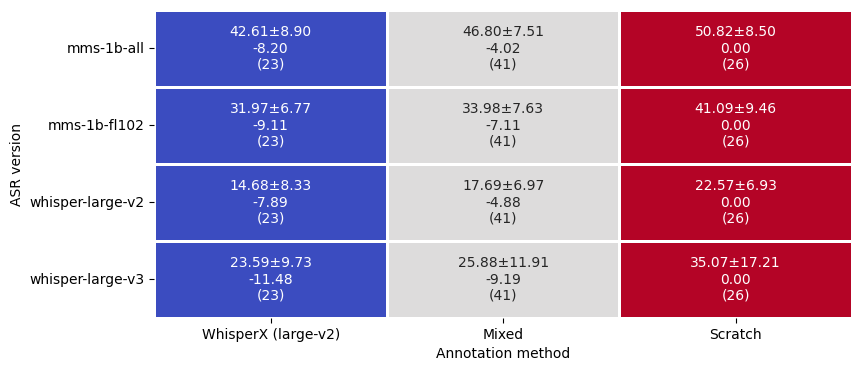

In [37]:
fig, ax = plt.subplots()
value_type = 'cer'
annot_types = df['annot_type'].unique()
asr_types = df['asr_type'].unique()

values = [[df[(df['asr_type'] == r) & (df['annot_type'] == c)][f'{value_type}_mean'].values[0] for c in annot_types] for r in asr_types]
labels = [[f"{df[(df['asr_type'] == r) & (df['annot_type'] == c)][f'{value_type}_mean'].values[0]:.2f}±{df[(df['asr_type'] == r) & (df['annot_type'] == c)][f'{value_type}_std'].values[0]:.2f}\n{df[(df['asr_type'] == r) & (df['annot_type'] == c)][f'{value_type}_mean'].values[0]-df[(df['asr_type'] == r) & (df['annot_type'] == 'scratch')][f'{value_type}_mean'].values[0]:.2f}\n({df[(df['asr_type'] == r) & (df['annot_type'] == c)]['count'].values[0]})" for c in annot_types] for r in asr_types]
tick_labels = ["mms-1b-all", "mms-1b-fl102", "whisperX-large-v2", "whisper-large-v3"]
values = [
    [1 if max(row) == v else (-1 if min(row) == v else 0) for v in row]
    for row in values
]
# mask = np.triu(np.ones_like(values, dtype=bool), k=1)
annot_types_labels = ["WhisperX (large-v2)" if 'whisper' in t else t.capitalize() for t in annot_types]
asr_types_labels = [t.replace('X', '') for t in asr_types]
sns.heatmap(values, annot=labels, ax=ax, xticklabels=annot_types_labels, yticklabels=asr_types_labels, fmt='', linecolor='white', linewidths=1, cmap='coolwarm', cbar=False)
ax.set_ylabel('ASR version')
ax.set_xlabel('Annotation method')
ax.grid(False)
fig.set_size_inches(9, 4)
fig.savefig(f'figures/bias_{value_type}.pdf', format='pdf', bbox_inches='tight')


In [38]:
# generate latex table
lines = [
    ["\multirow{2}{*}{ASR version}", "\multicolumn{3}{c}{Annotation method}", "\multirow{2}{*}{Mean}"],
    ["", "WhisperX", "Mixed", "Scratch",],
    ['\midrule']
]

for i, asr_type in enumerate(asr_types):
    cells = [asr_type]
    cells += [f"{df[(df['asr_type'] == asr_type) & (df['annot_type'] == c)][f'{value_type}_mean'].values[0]:.1f}±{df[(df['asr_type'] == asr_type) & (df['annot_type'] == c)][f'{value_type}_std'].values[0]:.1f}" for c in annot_types]
    asr_type_mean = rq3_df[rq3_df['asr_type'] == asr_type][value_type].mean()*100
    asr_type_std = (rq3_df[rq3_df['asr_type'] == asr_type][value_type]*100).std()
    cells.append(f"{asr_type_mean:.1f}±{asr_type_std:.1f}")
    lines.append(cells)

with open('tables/bias_cer.tex', 'w') as f:
    f.write(r"\begin{tabular}{l ccc r}" + "\n")
    f.write(r"\toprule" + "\n")
    for i, line in enumerate(lines):
        f.write(" & ".join(line) + r" \\" + "\n")
    f.write(r"\midrule" + "\n")
    f.write(r"Mean & ")
    f.write(" & ".join([f"{rq3_df[rq3_df['annot_type'] == c][value_type].mean()*100:.1f}±{(rq3_df[rq3_df['annot_type'] == c][value_type]*100).std():.1f}" for c in annot_types]) + r" \\" + "\n")
    f.write(r"Count & ")
    f.write(" & ".join([f"{len(rq3_df[rq3_df['annot_type'] == c]['cer'])//4:d}" for c in annot_types]) + r" \\" + "\n")
    f.write(r"\bottomrule" + "\n")
    f.write(r"\end{tabular}" + "\n")

In [ ]:
whispers = [w for w in asr_types if 'whisper' in w]
for annot_type in annot_types:
    print(annot_type)
    print(f"{rq3_df[(rq3_df['annot_type'] == annot_type) & (rq3_df['asr_type'].isin(whispers))]['cer'].mean()*100:0.2f}")
    print(f"{rq3_df[(rq3_df['annot_type'] == annot_type) & (rq3_df['asr_type'].isin(whispers))]['cer'].std()*100:0.2f}")

In [ ]:
whispers = [w for w in asr_types if 'whisper' in w]
for asr_type in asr_types:
    print(asr_type)
    print(f"& {rq3_df[(rq3_df['asr_type'] == asr_type)]['cer'].mean()*100:0.2f}±"
          f"{rq3_df[(rq3_df['asr_type'] == asr_type)]['cer'].std()*100:0.2f} ")

# RQ3 2.0


In [40]:
%load_ext autoreload
%autoreload 2
import uttalign
import utils


from Bio import pairwise2

uttaligner = uttalign.BioAligner()

counts = defaultdict(lambda: defaultdict(lambda: 0))
ff_examples = defaultdict(lambda: list())
num_docs = 0

for recname, annots in stats_recordings.items():
    # iterate over all pairs of transcripts
    for i, (annot1_name, annot1) in enumerate(annots.items()):
        for annot1_type in PREFERENCE_ORDER: 
            if annot1_type in annot1_name:
                break
        for user1 in ANNOTATOR_NAMES:
            if user1 in annot1_name:
                break
        for j, (annot2_name, annot2) in enumerate(annots.items()):
            if i >= j:
                continue
            for annot2_type in PREFERENCE_ORDER:
                if annot2_type in annot2_name:
                    break
            for user2 in ANNOTATOR_NAMES:
                if user2 in annot2_name:
                    break
            if annot1_type != 'mixed' and annot1_type != 'whisper':
                continue
            if annot2_type != 'scratch':
                continue
            # align the transcripts. It should be both_manual=True here, but the results are a bit weird and hard to explain. It needs to be investigated.
            # alignment = uttaligner.align_utterances(annot1, annot2, both_manual=True)
            alignment = uttaligner.align_utterances(annot1, annot2, both_manual=True)
            alignment_f = {i: j for i, j in alignment if len(i) > 0}

            asr_transcript = auto_annotations[annot1_name]
            annot12asr_alignment = uttaligner.align_utterances(annot1, asr_transcript, both_manual=False)
            annot12asr_alignment_f = {i: j for i, j in annot12asr_alignment if len(i) > 0}

            alignment, annot12asr_alignment = [], []
            for i, j in alignment_f.items():
                if i in annot12asr_alignment_f:
                    alignment.append((i, j))
                    annot12asr_alignment.append((i, annot12asr_alignment_f[i]))

            if len(alignment) != len(annot12asr_alignment):
                print(f"Alignment mismatch: {annot1_name} vs {annot2_name} ({len(alignment)} vs {len(annot12asr_alignment)})")
                print([a[0] for a in alignment])
                print([a[0] for a in annot12asr_alignment])
                continue
            
            def extract_text(indices, annot, quess_source=False):
                text = []
                for idx in indices:
                    source = annot[idx]['source']
                    if source is None and quess_source:
                        source = 'whisperX-large-v2'
                    text += [(t, source) for t in utils.normalize_text(annot[idx]['text'], char_level=False)]
                return text

            annot1_texts = [
                extract_text(i, annot1) for i, _ in alignment
            ]
            annot2_texts = [
                extract_text(j, annot2) for _, j in alignment
            ]
            annot12asr_texts = [
                extract_text(j, asr_transcript, quess_source=True) for _, j in annot12asr_alignment
            ]
            num_docs += 1
            for text1, text2, asr_text  in zip(annot1_texts, annot2_texts, annot12asr_texts):
                if len(text1) == 0 or len(text2) == 0 or len(asr_text) == 0:
                    continue

                t1 = " ".join([a[0] for a in text1])
                t2 = " ".join([a[0] for a in text2])
                text_score = uttaligner.text_score(t1, t2)
                text_score /= max(
                    len(utils.normalize_text(t1, char_level=True)),
                    len(utils.normalize_text(t2, char_level=True))
                )
                if text_score < 0.5:
                    print(t1)
                    print(t2)
                    print(text_score)
                    print()
                    continue

                plc1 = list(range(len(text1)))
                plc2 = list(range(len(text2)))
                asr_plc = list(range(len(asr_text)))
                alignmen1 = pairwise2.align.globalcx(plc1, plc2, one_alignment_only=True, gap_char=[None], match_fn=lambda x, y: uttaligner.text_score(text1[x][0], text2[y][0]))
                alignmen2 = pairwise2.align.globalcx(plc1, asr_plc, one_alignment_only=True, gap_char=[None], match_fn=lambda x, y: uttaligner.text_score(text1[x][0], asr_text[y][0]))
                alignmenSasr = pairwise2.align.globalcx(plc2, asr_plc, one_alignment_only=True, gap_char=[None], match_fn=lambda x, y: uttaligner.text_score(text2[x][0], asr_text[y][0]))
                alignmenSpost = pairwise2.align.globalcx(plc2, plc1, one_alignment_only=True, gap_char=[None], match_fn=lambda x, y: uttaligner.text_score(text2[x][0], text1[y][0]))
                def filter_alignemnt(align, text1, text2):
                    new_align = {}
                    for i, j in zip(align[0][0], align[0][1]):
                        if i is not None and j is not None:
                            new_align[i] = j
                        elif i is not None:
                            new_align[i] = None
                    return new_align
                alignmen1 = filter_alignemnt(alignmen1, text1, text2)
                alignmen2 = filter_alignemnt(alignmen2, text1, asr_text)
                alignmenSasr = filter_alignemnt(alignmenSasr, text2, asr_text)
                alignmenSpost = filter_alignemnt(alignmenSpost, text2, text1)
                covered2 = {j for _, j in alignmen1.items()}
                alignmenSasr = {i:j for i, j in alignmenSasr.items() if i is not None and i not in covered2}
                alignmenSpost = {i:j for i, j in alignmenSpost.items() if i is not None and i not in covered2}

                for i, j in alignmen2.items():
                    if i in alignmen1:
                        source = asr_text[j][1] if j is not None else None
                        if j is None:
                            li = i
                            while li >= 0:
                                if li in alignmen2 and alignmen2[li] is not None:
                                    break
                                li -= 1
                            ui = i
                            while ui < len(plc1):
                                if ui in alignmen2 and alignmen2[ui] is not None:
                                    break
                                ui += 1
                            if li in alignmen2 and alignmen2[li] is not None and ui in alignmen2 and alignmen2[ui] is not None:
                                source = asr_text[alignmen2[li]][1] if i - li < ui - i else asr_text[alignmen2[ui]][1]
                            elif li in alignmen2 and alignmen2[li] is not None:
                                source = asr_text[alignmen2[li]][1]
                            elif ui in alignmen2 and alignmen2[ui] is not None:
                                source = asr_text[alignmen2[ui]][1]
                            else:
                                continue

                        asr2a1 = asr_text[j][0] == text1[i][0] if j is not None else False
                        if asr2a1 and asr_text[j][0].isnumeric():
                            a12a2 = True
                        else:
                            a12a2 = text1[i][0] == text2[alignmen1[i]][0] if alignmen1[i] is not None else False
                        # if asr2a1 and not a12a2:
                        ff_examples[source].append((
                            asr_text[j][0] if j is not None else '', 
                            text1[i][0], 
                            text2[alignmen1[i]][0] if alignmen1[i] is not None else '', 
                            " ".join([a[0] for a in asr_text]), 
                            " ".join([a[0] for a in text1]), 
                            " ".join([a[0] for a in text2])))
                        # print(asr2a1, a12a2, asr_text[j][0], text1[i][0], text2[alignmen1[i]][0])
                        counts[source][(asr2a1, a12a2)] += 1
                
                for i, j in alignmenSasr.items():
                    if i in alignmenSpost:
                        source = asr_text[j][1] if j is not None else None
                        if j is None:
                            li = i
                            while li >= 0:
                                if li in alignmenSasr and alignmenSasr[li] is not None:
                                    break
                                li -= 1
                            ui = i
                            while ui < len(plc2):
                                if ui in alignmenSasr and alignmenSasr[ui] is not None:
                                    break
                                ui += 1
                            if li in alignmenSasr and alignmenSasr[li] is not None and ui in alignmenSasr and alignmenSasr[ui] is not None:
                                source = asr_text[alignmenSasr[li]][1] if i - li < ui - i else asr_text[alignmenSasr[ui]][1]
                                ui = li if i - li < ui - i else ui
                            elif li in alignmenSasr and alignmenSasr[li] is not None:
                                source = asr_text[alignmenSasr[li]][1]
                                ui = li
                            elif ui in alignmenSasr and alignmenSasr[ui] is not None:
                                source = asr_text[alignmenSasr[ui]][1]
                            else:
                                continue

                        if j is None and alignmenSpost[i] is None:
                            if text2[i][0] in {'stě', 'tři', 'šedesát', 'deset', 'padesát', 'dvě','osumnácti', 'tšicet'}:
                                continue
                            ff_examples[source].append((
                                "", 
                                text1[alignmenSpost[i]][0] if alignmenSpost[i] is not None else '', 
                                text2[i][0], 
                                " ".join([a[0] for a in asr_text]), 
                                " ".join([a[0] for a in text1]), 
                                " ".join([a[0] for a in text2]))
                            )
                            # print(ff_examples[source][-1])
                            counts[source][(True, False)] += 1
                        elif j is None and alignmenSpost[i] is not None:
                            agree = text2[i][0] == text1[alignmenSpost[i]][0]
                            counts[source][(False, agree)] += 1
                        elif j is not None and alignmenSpost[i] is None:
                            counts[source][(False, False)] += 1


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
hm výborně tak tak půjdeme ve středu a kam půjdeme máš nějaký nápad
pondělí se mi zrovna nehodí máš čas ve středu ano v čedu mám mám čas od osumnácti več od osumnácti výborně tak tak půjdeme ve středu a kam půjdeme máš nějaký nápad
0.4166666666666667

hm výborně tak tak půjdeme ve středu a kam půjdeme máš nějaký nápad
pondělí se mi zrovna nehodí máš čas ve středu ano v čedu mám mám čas od osumnácti več od osumnácti výborně tak tak půjdeme ve středu a kam půjdeme máš nějaký nápad
0.4166666666666667

ano můžu vám dát tento lék berte ho třikrát denně
ano
0.075

aha dobře
můžu vám dát tento lék berte ho třikrát denně aha dobře a je
0.16666666666666666

hm tak jo to můžu to mám čas a já bych ráda viděla ten nový film takový ten akční film který se jmenuje terminátor
hm tak jo to můžu to mám čas a
0.24175824175824176

chtěl bys ho vidět
já bych ráda viděla ten nový film takový ten akční film který se jmen

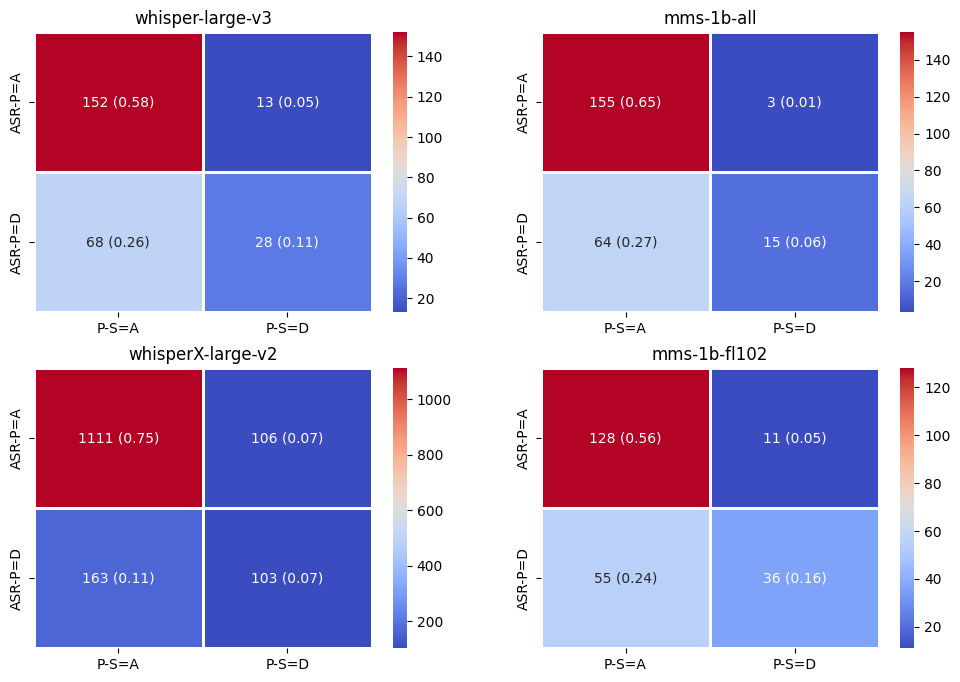

In [41]:
# plot confusion matrix for each source in counts
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))
for i, (source, c) in enumerate(counts.items()):
    values = [[c[(True, True)], c[(True, False)]], [c[(False, True)], c[(False, False)]]]
    labels = [[f"{c[(True, True)]} ({c[(True, True)]/sum(c.values()):.2f})", f"{c[(True, False)]} ({c[(True, False)]/sum(c.values()):.2f})"], [f"{c[(False, True)]} ({c[(False, True)]/sum(c.values()):.2f})", f"{c[(False, False)]} ({c[(False, False)]/sum(c.values()):.2f})"]]
    xtick_labels = ["P-S=A", "P-S=D"]
    ytick_labels = ["ASR-P=A", "ASR-P=D"]
    sns.heatmap(values, annot=labels, xticklabels=xtick_labels, yticklabels=ytick_labels, fmt='', linecolor='white', linewidths=1, cmap='coolwarm', ax=ax[i//2, i%2])
    ax[i//2, i%2].set_title(source)
    ax[i//2, i%2].grid(False)

fig.savefig('figures/ff_confusion.pdf', format='pdf', bbox_inches='tight')

In [21]:
for source, examples in ff_examples.items():
    print(f"Source: {source} {counts[source][(True, False)]} {len([e for e in examples if not e[0].isnumeric() and e[0] == e[1] != e[2]])}")
    for ex in examples:
        if ex[0] == ex[1] != ex[2] and not ex[0].isnumeric():
            print(ex)

Source: whisper-large-v3 13 13
('chci', 'chci', 'chcí', 'dám si 10 rohliků a chci jeden chleb', 'no dám ši deset ro deset roglikiv a chci j j jeden chl chleb', 'dám sí deset deset rohlíkův a chcí je je jeden chléb')
('chleb', 'chleb', 'chléb', 'dám si 10 rohliků a chci jeden chleb', 'no dám ši deset ro deset roglikiv a chci j j jeden chl chleb', 'dám sí deset deset rohlíkův a chcí je je jeden chléb')
('dort', 'dort', 'dorlt', 'kolik stojí ten dort', 'kolik stojí ten dort', 'kolik stojí ten dorlt')
('vlákem', 'vlákem', 'vlakem', 'vlákem třeba 30 minut a autobusem pět myslím že to je', 'vlá v vlákem trvá čicet minut a autobusem pět myslím že to je normální', 'vla vlakem tvá tšicet minut a autobusem pět myslim že to je nomální')
('děkuji', 'děkuji', 'děkuju', 'tak děkuji tak to prosím děkuji', 'hm tak děkuji', 'hm tak děkuju')
('dobře', 'dobře', 'dóbže', 'dobře jojo', 'dobře jojo', 'dóbže jo jo')
('jojo', 'jojo', 'jo', 'dobře jojo', 'dobře jojo', 'dóbže jo jo')
('pojít', 'pojít', 'být', '

# Auto to Manual Utterances alignment

In [ ]:
%load_ext autoreload
%autoreload 2
import uttalign

os.makedirs('alignment_test', exist_ok=True)

matrix_aligner = uttalign.MatrixAligner(threshold_overlap=0.05)
bio_aligner = uttalign.BioAligner()

for annot_file, manual_annotation in manual_annotations.items():
    if annot_file != "A2ML_221205_15-ZM-from_mixed.xml":
        continue
    print(f"Processing {annot_file}")
    auto_annotation = auto_annotations[annot_file]
    if not len(auto_annotation):
        continue
    matrix_alignment = matrix_aligner.align_utterances(manual_annotation, auto_annotation)
    with open(f'alignment_test/{annot_file}_matrix.txt', 'w') as f:
        for a, b in matrix_alignment:
            a_text = uttalign.extract_text(a, manual_annotation)
            b_text = uttalign.extract_text(b, auto_annotation)
            print(f"MANUAL: {a_text}", file=f)
            print(f"AUTO: {b_text}", file=f)
            print(file=f)

    bio_alignment = bio_aligner.align_utterances(manual_annotation, auto_annotation)
    with open(f'alignment_test/{annot_file}_bio.txt', 'w') as f:
        for a, b in bio_alignment:
            a_text = uttalign.extract_text(a, manual_annotation)
            b_text = uttalign.extract_text(b, auto_annotation)
            print(f"MANUAL: {a_text}", file=f)
            print(f"AUTO: {b_text}", file=f)
            print(file=f)

""" with open('alignments.txt', 'w') as f:
    for reference_asr, version in auto_recordings_versions.items():
        for recname, asr_transcript in version.items():
            recname = recname.replace('.xml', '.mp3')
            
            if recname not in manual_recordings:
                continue
                
            f.write(f"ASR version {reference_asr} for {recname}:\n")
            for annot_name, manual_transcript in manual_recordings[recname].items():

                alignment = align_utterances(manual_transcript,asr_transcript, )
                for idx, (a, b) in enumerate(zip(alignment[0][0], alignment[0][1])):
                    if b is not None:
                        al = []
                        if a is None:
                            a = find_best_alignment_for_auto(alignment[0], idx)
                        if a is not None:
                            al.extend(a['original_utterances'])
                        # print(b['original_utterances'])
                        f.write(f"{b['original_utterances']} -> {al}\n")
        #         break
        #     break
        # break
 """

## Notes
 - Using WhisperX segmentation biases the number of utterances (e.g., 07-npi-test-B1.mp3 with 161 and 273)

## Basic Stats

In [ ]:
# TODO: how to compute the total duration?
total_duration = sum(list(recording.values())[0][-1]['end'] - list(recording.values())[0][0]['start'] for recording in recordings.values())
print(f"Total recordings:  {len(recordings)}")
print(f"Total duration:    {total_duration:.02f} seconds ({total_duration/60:.02f} minutes)")

# TODO: should we take the max or select some specific version?
total_utterances = sum(max(len(utterances) for utterances in transcripts.values()) for transcripts in recordings.values())
print(f"Total utterances:  {total_utterances}")

total_words = sum(
    max(
        sum(
            len(utterance['text'].split())
            for utterance in transcript
        )
        for transcript in recording.values()
    )
 for recording in recordings.values())
print(f"Total words:       {total_words}")


num_versions_histogram = {}
for recording, transcripts in recordings.items():
    num_versions = len(transcripts)
    num_versions_histogram[num_versions] = num_versions_histogram.get(num_versions, 0) + 1
print(f"Version histogram: {num_versions_histogram}")

num_speakers_histogram = {}
for recording, transcripts in recordings.items():
    num_speakers = max(len(set([u['speaker'] for u in utterances])) for utterances in transcripts.values())
    num_speakers_histogram[num_speakers] = num_speakers_histogram.get(num_speakers, 0) + 1
print(f"Speaker histogram: {num_speakers_histogram}")


## Students Stats

In [ ]:
total_student_duration = sum(
    max(
        sum(
            utterance['end'] - utterance['start']
            for utterance in transcript
            if utterance['speaker'] != 't'
        )
        for transcript in recording.values()
    )
 for recording in recordings.values())
print(f"Total student duration:    {total_student_duration:.02f} seconds ({total_student_duration/60:.02f} minutes); {total_student_duration/total_duration*100:.02f}% of total duration")

total_student_utterances = sum(
    max(
        sum(
            utterance['speaker'] != 't'
            for utterance in transcript
        )
        for transcript in recording.values()
    )
 for recording in recordings.values())
print(f"Total student utterances:  {total_student_utterances} ({total_student_utterances/total_utterances*100:.02f}% of total utterances)")

total_student_words = sum(
    max(
        sum(
            len(utterance['text'].split())
            for utterance in transcript
            if utterance['speaker'] != 't'
        )
        for transcript in recording.values()
    )
 for recording in recordings.values())
print(f"Total student words:       {total_student_words} ({total_student_words/total_words*100:.02f}% of total words)")

## Level Stats

In [ ]:
for level in ['A1', 'A2', 'B1', 'B2', 'C1']:
    relevant = [transcript_version_select(r) for n, r in recordings.items() if level in n]
    
    duration = sum(transcript[-1]['end'] - transcript[0]['start'] for transcript in relevant)
    print(f'{level}: {len(relevant)} recordings; {duration:.02f} seconds ({duration/60:.02f} minutes)')

    

## Inter-annotator Agreement

## Obsolete code

In [ ]:
from collections import defaultdict

from Bio.pairwise2 import format_alignment

%load_ext autoreload
%autoreload 2
import uttalign
import utils

os.makedirs('alignments/rq1.1', exist_ok=True)

#annot2texts = {k: concat_texts_by_speaker(v) for k, v in before_review_annotations.items()}
final_auto_annot_pairs = {annot_name:(before_review_annotations[annot_name], auto_annotations[annot_name]) for annot_name in before_review_annotations}

annot2edit_distances = defaultdict(lambda: 0)
annot2numwords = defaultdict(lambda: 0)
edit_counts = defaultdict(lambda: 0)
to_lengths = defaultdict(lambda: 0)

#aligner = uttalign.BioAligner()
aligner = uttalign.MatrixAligner(threshold_overlap=0.1)

for annot_name, (to_annot, from_annot) in final_auto_annot_pairs.items():
    for transcript_type in PREFERENCE_ORDER:
        if transcript_type in annot_name:
            break

    utt_alignment = aligner.align_utterances(to_annot, from_annot)

    aligned_texts = [(uttalign.extract_text(i, to_annot), uttalign.extract_text(j, from_annot)) for i, j in utt_alignment]
    aligned_speakers = [(uttalign.extract_speaker(i, to_annot), uttalign.extract_speaker(j, from_annot)) for i, j in utt_alignment]

    for (to_text, from_text), (to_speaker, from_speaker) in zip(aligned_texts, aligned_speakers):
        speaker_type = to_speaker
        if to_speaker is not None:
            for speaker_type in SPEAKER_TYPES:
                if speaker_type.lower() in to_speaker.lower():
                    break
        l = len(utils.normalize_text(to_text))
        #print(before_review_text, auto_text)
        agree, disagree, word_alignment = uttalign.align_texts(to_text, from_text)
        # if l and disagree / l > 0.9:
        #     print(f"{annot_name} {before_review_speaker} {transcript_type} {agree} {disagree}")
        with open(f'alignments/rq1.1/{annot_name}_{to_speaker}.txt', 'w') as f:
            if word_alignment is not None:
                f.write(format_alignment(*word_alignment))
        if speaker_type:
            edit_counts[f"{transcript_type}:{speaker_type}"] += disagree
            to_lengths[f"{transcript_type}:{speaker_type}"] += l
        edit_counts[transcript_type] += disagree
        to_lengths[transcript_type] += l
        annot2edit_distances[annot_name] += disagree
        annot2numwords[annot_name] += l

print('Edit distances:     ', "\t".join([f"{k}:{v}" for k, v in edit_counts.items()]))
print('Total characters:   ', "\t".join([f"{k}:{v}" for k, v in to_lengths.items()]))
print('Edits per character:', "\t".join([f"{k}:{v / to_lengths[k]:.2f}" for k, v in edit_counts.items()]))

columns = ['whisper', 'mixed']
values = [to_lengths[c] for c in columns]
relativ = [edit_counts[c] / to_lengths[c] for c in columns]
fig, ax = plt.subplots()
ax.bar(columns, relativ)
ax.set_ylabel('Edit distance per word')

# Bio
# Edit distances:      whisper:exam:1112	whisper:2721	whisper:cand:1602	mixed:exam:3549	mixed:9251	mixed:cand:5698	scratch:cand:3413	scratch:7237	scratch:exam:3824
# Total characters:    whisper:exam:7676	whisper:12991	whisper:cand:5315	mixed:exam:13174	mixed:23351	mixed:cand:10177	scratch:cand:3413	scratch:7237	scratch:exam:3824
# Edits per character: whisper:exam:0.14	whisper:0.21	whisper:cand:0.30	mixed:exam:0.27	mixed:0.40	mixed:cand:0.56	scratch:cand:1.00	scratch:1.00	scratch:exam:1.00


### Comparison over the recordings that were both manually transcribed and manually post-edited. Total duration. Total edit distance.

In [ ]:
stats_annot_durations = before_review_annot_durations

durations = defaultdict(lambda: 0)
annotdurations = defaultdict(lambda: 0)
edits = defaultdict(lambda: 0)
words = defaultdict(lambda: 0)

for annot_name in before_review_annotations.keys():
    for t in PREFERENCE_ORDER:
        if t in annot_name:
            break
    #if -1 < stats_annot_durations[annot_name] < 10000: #TODO: this is 
    durations[t] += annotation2duration[annot_name]
    annotdurations[t] += stats_annot_durations[annot_name]
    edits[t] += annot2edit_distances[annot_name]
    words[t] += annot2numwords[annot_name]


print('Total times: ', durations)
print('Edit distances:', edits)
print('Annot to recording ratio:', [(k, annotdurations[k] / v) for k, v in durations.items()])
print('Annot time per word:', [(k, annotdurations[k] / v) for k, v in words.items()])
print('Annot duration per edit:', [(k, annotdurations[k] / v) for k, v in edits.items()])
print('Edit distance per word:', [(k, v / words[k]) for k, v in edits.items()])

In [ ]:
relevant_recordings = [k for k, v in before_review_recordings.items() if any(['scratch' in a for a in v.keys()]) and len(v) > 1]

total_words = {}
total_duration = {}
total_edits = {}
total_annot_duration = {}

for recording in relevant_recordings:
    for annot_name in auto_recordings[recording]:
        for t in PREFERENCE_ORDER:
            if t in annot_name:
                break
        if t not in annot_name:
            continue
        if -1 < annotation2annot_duration[annot_name] < 10000: #TODO: this is 
            total_words[t] = total_words.get(t, 0) + annot2numwords[annot_name]
            total_duration[t] = total_duration.get(t, 0) + annotation2duration[annot_name]
            total_edits[t] = total_edits.get(t, 0) + annot2edit_distances[annot_name]
            total_annot_duration[t] = total_annot_duration.get(t, 0) + annotation2annot_duration[annot_name]

print('Relevant recordings:', len(relevant_recordings))
print('Total words: ', total_words)
print('Total duration:', total_duration)
print('Total edits:', total_edits)
print('Total annot duration:', total_annot_duration)
print('Edits per word:', [(k, total_edits[k] / v) for k, v in total_words.items()])
print('Duration per edit:', [(k, v / total_edits[k]) for k, v in total_duration.items()])
print('Annot duration per edit:', [(k, v / total_edits[k]) for k, v in total_annot_duration.items()])
print('Annot duration per word:', [(k, v / total_words[k]) for k, v in total_annot_duration.items()])

### Do the duration and edit distance correlate?
TODO

### Is there a significant difference across annotators? Some might prefer one way of transcribing over the other.


In [ ]:
def parse_annotator(annot_name):
    n = annot_name.split('from')[0]
    n = n[:-1].split('-')[-1]
    assert len(n) > 0   
    return n

total_words = {}
total_duration = {}
total_edits = {}
total_annot_duration = {}

annotators = set([parse_annotator(a) for a in auto_annotations.keys()])



for recording in manual_recordings.keys():
    for annot_name in manual_recordings[recording]:
        for t in PREFERENCE_ORDER:
            if t in annot_name:
                break
        if t not in annot_name:
            continue

        if -1 < annotation2annot_duration[annot_name] < 10000: #TODO: this is 
            annotator = parse_annotator(annot_name)
            total_words[f'{t}_{annotator}'] = total_words.get(f'{t}_{annotator}', 0) + annot2numwords[annot_name]
            total_duration[f'{t}_{annotator}'] = total_duration.get(f'{t}_{annotator}', 0) + annotation2duration[annot_name]
            total_edits[f'{t}_{annotator}'] = total_edits.get(f'{t}_{annotator}', 0) + annot2edit_distances[annot_name]
            total_annot_duration[f'{t}_{annotator}'] = total_annot_duration.get(f'{t}_{annotator}', 0) + annotation2annot_duration[annot_name]

print('Annotators:', annotators)
# print('Total words: ', total_words)
# print('Total duration:', total_duration)
# print('Total edits:', total_edits)
# print('Total annot duration:', total_annot_duration)
print('Edits per word:', sorted([(k, total_edits[k] / v) for k, v in total_words.items()], key=lambda x: x[0]))
print()
print('Annot duration per word:', sorted([(k, total_annot_duration[k] / v) for k, v in total_words.items()], key=lambda x: x[0]))
print()
# print('Duration per edit:', [(k, v / total_edits[k]) for k, v in total_duration.items()])
print('Annot duration per edit:', sorted([(k, v / total_edits[k]) for k, v in total_annot_duration.items()], key=lambda x: x[0]))


In [ ]:

columns = ['whisper', 'mixed', 'scratch']
rows = list(annotators)
values = {k: total_annot_duration[k] / v for k, v in total_words.items()}
# plot a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
table = [[values.get(f'{c}_{r}', -1) for c in columns] for r in rows]
table, rows = zip(*[(t, r) for t, r in zip(table, rows) if any([v > 0 for v in t])])
sns.heatmap(table, annot=True, ax=ax, xticklabels=columns, yticklabels=rows)
ax.set_xlabel('Before annotation transcript')
ax.set_ylabel('Annotator')
ax.set_title('Annotaton duration per word')


In [ ]:
columns = ['whisper', 'mixed', 'scratch']
rows = list(annotators)
values = {k: total_annot_duration[k] / v for k, v in total_duration.items()}
# plot a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
table = [[values.get(f'{c}_{r}', -1) for c in columns] for r in rows]
table, rows = zip(*[(t, r) for t, r in zip(table, rows) if any([v > 0 for v in t])])
sns.heatmap(table, annot=True, ax=ax, xticklabels=columns, yticklabels=rows)
ax.set_xlabel('Preference')
ax.set_ylabel('Annotator')
ax.set_title('Annotator duration per recording duration')

### Word-level IAA 

In [ ]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from mosestokenizer import MosesTokenizer, MosesPunctuationNormalizer

if not os.path.exists('alignments'):
    os.makedirs('alignments')

punct_normalizer = MosesPunctuationNormalizer('cs')
tokenizer = MosesTokenizer('cs')

def normalize_text(text):
    text = text.lower().replace('\n', " ")
    text = punct_normalizer(text)
    text = tokenizer(text)
    return [t for t in text if t.isalnum()]

def align_texts_w(text1, text2):
    text1 = normalize_text(text1)
    text2 = normalize_text(text2)
    alignments = pairwise2.align.globalxs(text1, text2, one_alignment_only=True, gap_char=['-'], open=-1, extend=-1)
    
    agree, disagree = 0, 0
    for a, b in zip(alignments[0][0], alignments[0][1]):
        if a == b:
            agree += 1
        else:
            disagree += 1
    return agree, disagree, alignments[0]

def align_texts(text1, text2):
    text1 = list("".join(normalize_text(text1)))
    text2 = list("".join(normalize_text(text2)))
    alignments = pairwise2.align.globalxs(text1, text2, one_alignment_only=True, open=-1, extend=-1, gap_char=['-'])
    
    agree, disagree = 0, 0
    for a, b in zip(alignments[0][0], alignments[0][1]):
        if a == b:
            agree += 1
        else:
            disagree += 1
    return agree, disagree, alignments[0]


relevant = {n: r for n, r in before_review_recordings.items() if len(r) > 1}

def get_type(name):
    if 'whisper' in name:
        return 'whisper'
    if 'mixed' in name:
        return 'mixed'
    if 'scratch' in name:
        return 'scratch'
    return 'unknown'

agreements = defaultdict(lambda: 0)
disagreements = defaultdict(lambda: 0)
num_recordings = defaultdict(lambda: 0)

aligner = uttalign.BioAligner()

for name, transcripts in relevant.items():
    transcripts = list(transcripts.items())
    print(f"Recording {name}")
    for idx, (annotation_name1, transcript1) in enumerate(transcripts):
        for annotation_name2, transcript2 in transcripts[idx+1:]:
            alignment = aligner.align_utterances(transcript1, transcript2, both_manual=True)
            aligned_texts = [(uttalign.extract_text(i, transcript1), uttalign.extract_text(j, transcript2)) for i, j in alignment]
            aligned_speakers = [(uttalign.extract_speaker(i, transcript1), uttalign.extract_speaker(j, transcript2)) for i, j in alignment]

            annot_agree, annot_disagree = 0, 0   
            for (t1, t2), (s1, s2) in zip(aligned_texts, aligned_speakers):
                agree, disagree, _ = uttalign.align_texts(t1, t2)
                # if s1 != s2 and len(t1) > 0 and len(t2) > 0:
                #     print(f"Speaker mismatch: {s1} vs {s2}")
                #     print(t1)
                #     print('-'*20)
                #     print(t2)
                #     print("="*20)
                #     print()
                t1 = get_type(annotation_name1)
                t2 = get_type(annotation_name2)


                
                
                annot_agree += agree
                annot_disagree += disagree
            if t1 == "mixed" and t2 == "mixed":
                print(f"MIXED vs. MIXED: {annotation_name1} {annotation_name2}")
              
            #print(f"  {annotation_name1} vs {annotation_name2} :\t {annot_agree / (annot_agree + annot_disagree)*100:.02f}% agreement\t {annot_agree} agree, {annot_disagree} disagree")
            if annot_agree / (annot_agree + annot_disagree) < 0.6:  
                continue
                
            agreements[t1, t2] += annot_agree
            disagreements[t1, t2] += annot_disagree
            agreements[t2, t1] = agreements[t1, t2]
            disagreements[t2, t1] = disagreements[t1, t2]
            num_recordings[t1, t2] += 1
            num_recordings[t2, t1] = num_recordings[t1, t2]

            # for speaker in speakers:
            #     if speaker not in t1 or speaker not in t2:
            #         continue
            #     agree, disagree, alignment = align_texts(t1[speaker], t2[speaker])
                
            #     speaker = 'teacher' if speaker == 't' else 'student ' + speaker
            #     print(f"  {n1} vs {n2} ({speaker}):\t {agree/(agree+disagree)*100:.02f}% agreement\t {agree} agree, {disagree} disagree")
            #     if agree / (agree + disagree) < 0.25:
            #         continue
            #     agreements[get_type(n1), get_type(n2)] = agreements.get((get_type(n1), get_type(n2)), 0) + agree
            #     disagreements[get_type(n1), get_type(n2)] = disagreements.get((get_type(n1), get_type(n2)), 0) + disagree
                
            #     agreements[get_type(n2), get_type(n1)] = agreements[get_type(n1), get_type(n2)]
            #     disagreements[get_type(n2), get_type(n1)] = disagreements[get_type(n1), get_type(n2)]

            #     with open(f'alignments/{name}_{n1}_{n2}_{speaker}.txt', 'w') as f:
            #         f.write(format_alignment(*alignment))
            #         f.write(f"\n{agree/(agree+disagree)*100:.02f}% agreement\t {agree} agree, {disagree} disagree\n")



print(agreements)
print(disagreements)
print({k: v / (disagreements[k] + v) for k, v in agreements.items()})

# plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.heatmap([[agreements.get((r, c), 0) / (disagreements.get((r, c), 0) + agreements.get((r, c), 1)) for c in ['whisper', 'mixed', 'scratch']] for r in ['whisper', 'mixed', 'scratch']], annot=True, ax=ax, xticklabels=['whisper', 'mixed', 'scratch'], yticklabels=['whisper', 'mixed', 'scratch'])
ax.set_xlabel('Reference')
ax.set_ylabel('Hypothesis')
